In [31]:
from PyQt6.QtWidgets import QApplication, QFileDialog
import sys
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime
from numpy import squeeze, arange, savetxt
from pandas import DataFrame, read_csv
from lmfit import Model

import db_image_analysis as db

# Settings

In [2]:
file_roi = 'results/20250312_1003_roi_selected.txt'

In [3]:
directory = None

# Load calibration data

In [4]:
df = read_csv(file_roi, index_col=[0, 1])
df.head(10)

mean       STS
0  roi1  0.751620  0.048560
   roi2  0.768782  0.026306
   roi3  0.831146  0.050476
   roi4  0.950444  0.050082
   roi5  0.741034  0.027013
   roi6  1.105680  0.046150
10 roi1  0.751620  0.048560
   roi2  0.768782  0.026306
   roi3  0.831146  0.050476
   roi4  0.950444  0.050082

Calculate the average of all RoI

In [5]:
data = df.groupby(df.index.get_level_values(0)).mean()
data.index.name = 'O2_pc_airsat'

data

,mean,STS
O2_pc_airsat,,
0,0.858118,0.041431
10,0.858118,0.041431
25,0.858118,0.041431
50,0.858118,0.041431
80,0.858118,0.041431
100,0.858118,0.041431


As the images used are dummy data which would not result in a correct calibration curve, I continue here with other dummy data for representative reasons.

In [6]:
data = DataFrame([[2.8100, 2.340, 1.9001, 1.30, 0.9977, 0.84881], 
                  [0.1600, 0.091300, 0.1047, 0.0873, 0.055729, 0.3638]], 
                 columns=[0, 10, 25, 50, 80, 100], index=['Mean', 'STD']).T 
data.index.name = 'O2_pc_airsat'
data

,Mean,STD
O2_pc_airsat,,
0,2.81000,0.160000
10,2.34000,0.091300
25,1.90010,0.104700
50,1.30000,0.087300
80,0.99770,0.055729
100,0.84881,0.363800


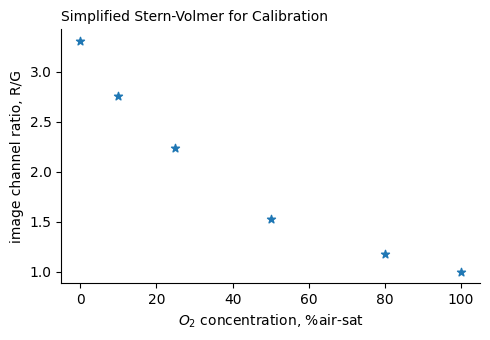

In [7]:
%matplotlib inline

arg = dict({'title': 'Simplified Stern-Volmer for Calibration', 
            'xlabel': '$O_2$ concentration, %air-sat', 
            'ylabel': 'image channel ratio, R/G',})

fig, ax = db.display_calibration_points(data=data, column_plot='Mean', arg=arg)

# Get Calibration function (Simplified Stern-Volmer)

### data preparation

In [8]:
# the model works with I0/I(c), meaning data must be normalized accordingly: 
## Divide the intensity under absense of oxygen I0 by the intensity at a certain O2 concentraiton I(c)
data_norm = data.Mean.loc[0] / data.Mean
data_norm

O2_pc_airsat
0      1.000000
10     1.200855
25     1.478870
50     2.161538
80     2.816478
100    3.310517
Name: Mean, dtype: float64

## define the model and model parameters

The model used is the simplified two-site model according to Wolfbeis 

In [9]:
simply_sv = Model(db.sternvolmer_simple)

y = data_norm.values
x = data_norm.index.to_numpy()

# set initial parameter
params_sens = simply_sv.make_params(k=0.165, f=0.887) # from previous calibrations approximately known
params_sens['k'].min = 0.
params_sens['f'].max = 1.

### compute run 1

In [10]:
result1 = simply_sv.fit(y, params_sens, x=x, nan_policy='omit')
result1

A good parameter to interpret the goodness of fit is the _reduced chi-square_ in combination with the residuals (plotted below).

- _reduced chi-square_ should be low as possible 
- residuals should be distributed randomly around zero

If unsure, run the model again by keeping one parameter fixed. Check if the outcome (best value of fitting parameters) change drastically or not. Else repeat the entire fitting by changing the initital parameter values completely and see if optiomal fit parameter can be obtained and the model converges.

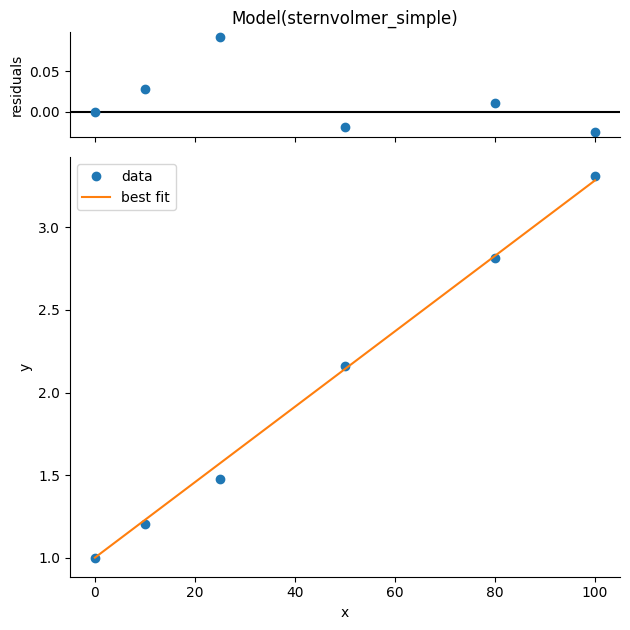

In [11]:
result1.plot()

sns.despine()
plt.tight_layout()
plt.show()

### fit 2nd round whith first parameter fixed

In [12]:
# to optimize the fit (and be sure of the parameter) >> 2nd round with one parameter fixed
params_sens2 = params_sens.copy()
params_sens2['k'].value = result1.best_values['k']
params_sens2['k'].vary = False
params_sens2['f'].value = result1.best_values['f']

params_sens2['f'].min = 0.
params_sens2['f'].max = 1.
result2 = simply_sv.fit(y, params_sens2, x=x, nan_policy='omit')
result2

/Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/.venv/lib/python3.12/site-packages/lmfit/printfuncs.py:393: RuntimeWarning: divide by zero encountered in scalar divide
  spercent = f'({abs(par.stderr/par.value):.2%})'


In [13]:
if result2.redchi < result1.redchi:
    print('second run has an improved reduced Chi square')
    result = result2
else:
    result = result1

reduced chi square minimal better for the second run than for the first but the actual values are the same as for the first run >> stop here and take these values

In [14]:
df_bestFit_preSens_norm = DataFrame(1 / result.best_fit, index=x)
df_bestFit_preSens = DataFrame(data.loc[0, 'Mean'] / result.best_fit, index=x, columns=['intensity_norm'])
df_bestFit_preSens

,intensity_norm
0,2.810000
10,2.287344
25,1.788388
50,1.311557
80,0.993641
100,0.855410


In [15]:
fit_paras = dict({'I0': data.loc[0, 'Mean'], 
                  'f': result.best_values['f'], 'k': result.best_values['k']})
fit_paras

{'I0': np.float64(2.81),
 'f': np.float64(-307049.54109177715),
 'k': np.float64(7.44177153233494e-08)}

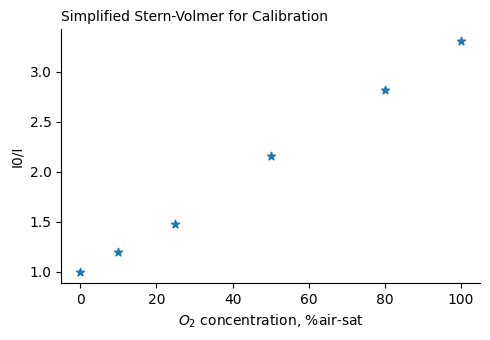

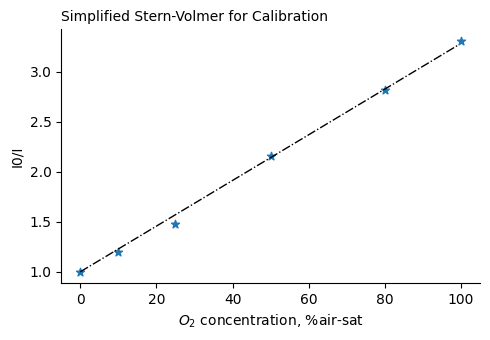

In [16]:
%matplotlib inline

arg = dict({'title': 'Simplified Stern-Volmer for Calibration', 
            'xlabel': '$O_2$ concentration, %air-sat', 
            'ylabel': 'I0/I',})

fig, ax = db.display_calibration_points(data=data_norm.to_frame(), column_plot='Mean', arg=arg);

xnew = arange(0, 100)
ax.plot(xnew, db.sternvolmer_simple(x=xnew, f=fit_paras['f'], k=fit_paras['k']), lw=1, color='k', ls='-.');
fig.canvas.draw()
fig

## save fit results

In [17]:
# best fit for parameter done... save report in case you want
now = datetime.now()
time_now = now.strftime('%Y%m%d-%H%M')

# save fit report to a file:
with open(f"{file_roi.split('/')[0]}/{time_now}_fit_result.txt", 'w') as fh:
    fh.write(result.fit_report())
    fh.write(f"\n    I0:\t{fit_paras['I0']}")

# Apply Calibration Function to other Data / Images

### Load fit parameters (if not continued from before)

In [17]:
file_fit = 'results/20250312-1127_fit_result.txt'

In [18]:
fit_results = db.read_fit_results(file_fit)
fit_results

{'Model': 'sternvolmer_simple',
 'Fit Statistics': {'# function evals': 3221.0,
  '# data points': 6.0,
  '# variables': 2.0,
  'chi-square': 0.01044533,
  'reduced chi-square': 0.00261133,
  'Akaike info crit': -34.1201587,
  'Bayesian info crit': -34.5366398,
  'R-squared': 0.99758223},
 'Variables': {'f': {'value': -307049.541, 'error': 2465200000.0},
  'k': {'value': 7.4418e-08, 'error': 0.00059755},
  'I0': 2.81},
 'Correlations': {'f-k': 1.0},
 'I0': None}

In [19]:
fit_paras = dict()
for param in ['I0', 'f', 'k']:
    if isinstance(fit_results['Variables'][param], dict):
        fit_paras[param] = fit_results['Variables'][param]['value']
    else:
        fit_paras[param] = fit_results['Variables'][param]
fit_paras

{'I0': 2.81, 'f': -307049.541, 'k': 7.4418e-08}

### Get image channels

In [20]:
if 'app' not in globals():
    app = QApplication(sys.argv)

directory = QFileDialog.getExistingDirectory(None, "Select Directory")
print("Selected Directory:", directory)

2025-03-12 11:58:58.245 Python[23783:822000] +[IMKClient subclass]: chose IMKClient_Modern


Selected Directory: /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/data/single_channels


In [21]:
files_r = [file for file in glob(directory + '/*_R.jpg')]
files_g = [file for file in glob(directory + '/*_G1.jpg')]
files_r

['/Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/data/single_channels/IMG_6698_O2optode_50pc-airsat_R.jpg',
 '/Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/data/single_channels/IMG_6700_O2optode_100pc-airsat_R.jpg',
 '/Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/data/single_channels/IMG_6696_O2optode_10pc-airsat_R.jpg',
 '/Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/data/single_channels/IMG_6699_O2optode_80pc-airsat_R.jpg',
 '/Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/data/single_channels/IMG_6697_O2optode_25pc-airsat_R.jpg',
 '/Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/data/single_channels/IMG_6695_O2optode_0pc-airsat_R.jpg']

In [22]:
images_r = db.load_and_stack(files_r)
images_g = db.load_and_stack(files_g)
images_r, images_g

(array([[[26, 26, 26, ..., 18, 18, 19],
         [27, 27, 27, ..., 17, 17, 18],
         [28, 27, 26, ..., 17, 17, 17],
         ...,
         [84, 84, 80, ..., 35, 31, 33],
         [84, 84, 80, ..., 37, 31, 31],
         [84, 84, 79, ..., 38, 31, 29]],
 
        [[26, 26, 26, ..., 18, 18, 19],
         [27, 27, 27, ..., 17, 17, 18],
         [28, 27, 26, ..., 17, 17, 17],
         ...,
         [84, 84, 80, ..., 35, 31, 33],
         [84, 84, 80, ..., 37, 31, 31],
         [84, 84, 79, ..., 38, 31, 29]],
 
        [[26, 26, 26, ..., 18, 18, 19],
         [27, 27, 27, ..., 17, 17, 18],
         [28, 27, 26, ..., 17, 17, 17],
         ...,
         [84, 84, 80, ..., 35, 31, 33],
         [84, 84, 80, ..., 37, 31, 31],
         [84, 84, 79, ..., 38, 31, 29]],
 
        [[26, 26, 26, ..., 18, 18, 19],
         [27, 27, 27, ..., 17, 17, 18],
         [28, 27, 26, ..., 17, 17, 17],
         ...,
         [84, 84, 80, ..., 35, 31, 33],
         [84, 84, 80, ..., 37, 31, 31],
         [84, 8

### Calculate Channel Ratio

In [23]:
stack_ratio = db.calculate_channel_ratio(images_r, images_g)

Stack_R shape: (6, 2196, 2939)
Stack_G1 shape: (6, 2196, 2939)

 >> Ratio stack computed with shape: (6, 2196, 2939)


### Apply reversed simplified stern-volmer equation

In [24]:
db.reverse_sternvolmer?

Signature: db.reverse_sternvolmer(int_norm: numpy.ndarray, f: float, k: float)
Docstring:
_summary_
Reverse stern-volmer equation calculating the analyte concentration based on given fitting parameters and a 
normalized intenstiy ratio for a given image. The reversed function used is: 
(1 / k) * ( (f / (int_norm - (1 - f))) - 1)
Args:
    int_norm (np.ndarray): normalized intensity ratio given as ndarray. The normalization is done as I0/I with I0 
                           being the luminescence intensity in the absence of the target analyte.
    f (float): fitting parameter f for stern volmer equation
    k (float): fitting parameter k for stern volmer equation

Returns:
    _type_: optional either None if no concentration can be calulated (when either k is 0 or I/I0 equals 1-f) or an 
            ndarray presenting the analyte concentration
File:      ~/Python/enviPatable/Python_Intro+ImageAnalysis/db_image_analysis.py
Type:      function

In [25]:
int_norm = fit_paras['I0']/stack_ratio
int_norm

/var/folders/lx/z70mzvpx4ls9np3hfbhll4wr0000gn/T/ipykernel_23783/2760790020.py:1: RuntimeWarning: divide by zero encountered in divide
  int_norm = fit_paras['I0']/stack_ratio


array([[[1.2969232, 1.2969232, 1.1888462, ..., 1.0927778, 1.0927778,
         0.8873685],
        [1.3529631, 1.3529631, 1.3529631, ..., 1.157059 , 1.157059 ,
         1.0927778],
        [1.5053571, 1.4570371, 1.4050001, ..., 1.157059 , 1.157059 ,
         1.322353 ],
        ...,
        [1.9067857, 1.9067857, 1.861625 , ..., 2.4085715, 2.3567743,
         2.469394 ],
        [1.9067857, 1.9067857, 1.861625 , ..., 2.4302702, 2.3567743,
         2.3567743],
        [1.9067857, 1.9067857, 1.8496202, ..., 2.5142105, 2.3567743,
         2.4224138]],

       [[1.2969232, 1.2969232, 1.1888462, ..., 1.0927778, 1.0927778,
         0.8873685],
        [1.3529631, 1.3529631, 1.3529631, ..., 1.157059 , 1.157059 ,
         1.0927778],
        [1.5053571, 1.4570371, 1.4050001, ..., 1.157059 , 1.157059 ,
         1.322353 ],
        ...,
        [1.9067857, 1.9067857, 1.861625 , ..., 2.4085715, 2.3567743,
         2.469394 ],
        [1.9067857, 1.9067857, 1.861625 , ..., 2.4302702, 2.3567743,
   

In [26]:
oxygen_concentration = db.reverse_sternvolmer(int_norm=int_norm, f=fit_paras['f'], k=fit_paras['k'])
oxygen_concentration

array([[[14.41699  , 14.41699  ,  8.009439 , ...,  4.8056636,
          4.8056636, -5.6066074],
        [14.41699  , 14.41699  , 14.41699  , ...,  6.4075513,
          6.4075513,  4.8056636],
        [22.42643  , 20.824541 , 17.620766 , ...,  6.4075513,
          6.4075513, 14.41699  ],
        ...,
        [40.047195 , 40.047195 , 38.44531  , ..., 60.87174  ,
         59.269848 , 64.075516 ],
        [40.047195 , 40.047195 , 38.44531  , ..., 62.473625 ,
         59.269848 , 59.269848 ],
        [40.047195 , 40.047195 , 36.84342  , ..., 65.6774   ,
         59.269848 , 62.473625 ]],

       [[14.41699  , 14.41699  ,  8.009439 , ...,  4.8056636,
          4.8056636, -5.6066074],
        [14.41699  , 14.41699  , 14.41699  , ...,  6.4075513,
          6.4075513,  4.8056636],
        [22.42643  , 20.824541 , 17.620766 , ...,  6.4075513,
          6.4075513, 14.41699  ],
        ...,
        [40.047195 , 40.047195 , 38.44531  , ..., 60.87174  ,
         59.269848 , 64.075516 ],
        [40.

In [27]:
oxygen_concentration.min(), oxygen_concentration.max()

(np.float32(-13437609.0), np.float32(5001.0938))

Of course the data do not make sense here, but for the demonstration of the pipeline. You would need to add a reasonable range for the concentration range

## Display Result

In [28]:
vmin, vmax = 0, 100

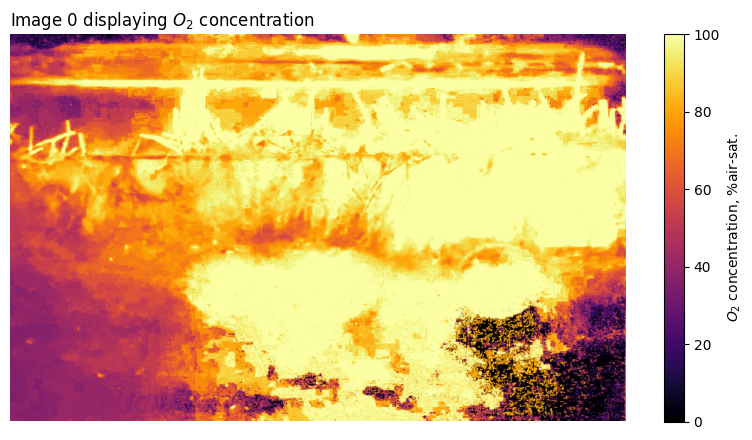

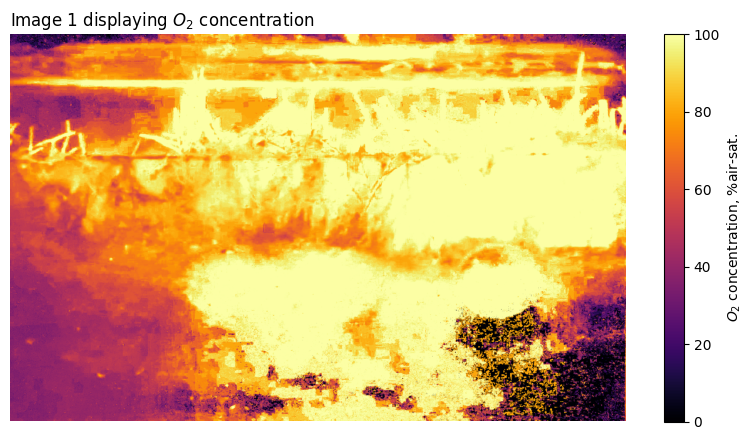

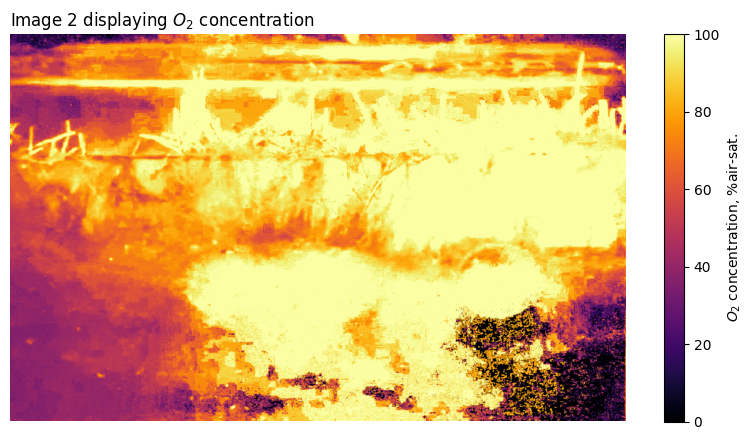

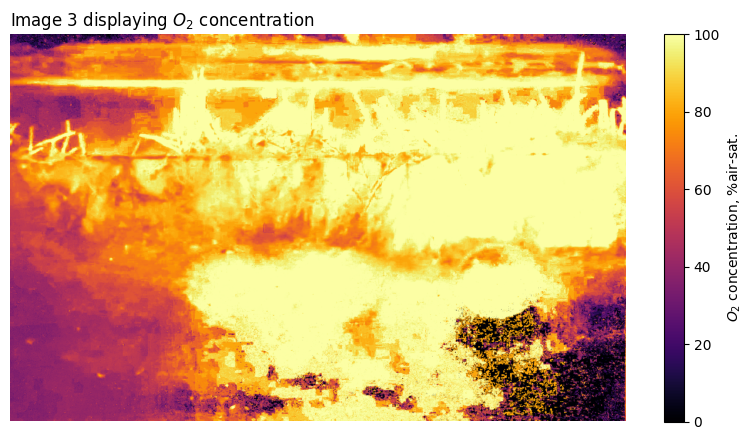

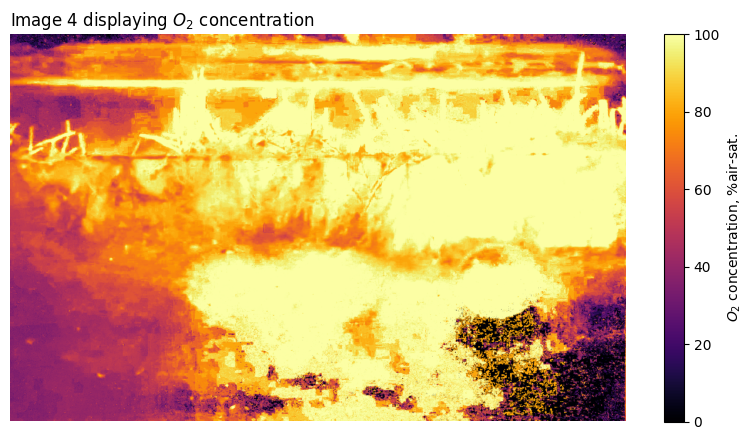

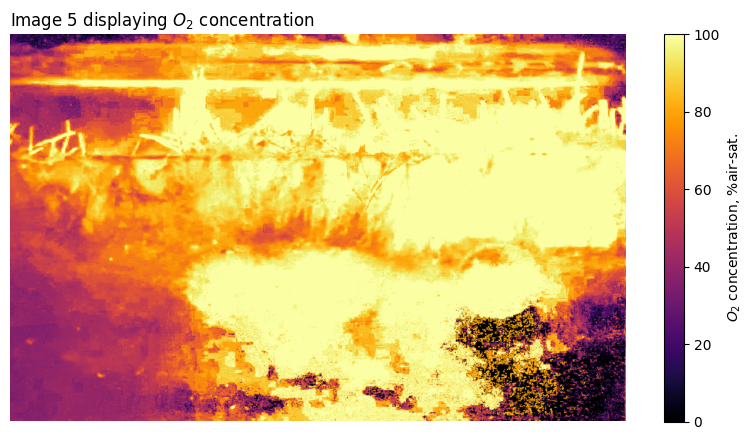

In [29]:
for en, image in enumerate(oxygen_concentration):
    plt.figure(figsize=(8, 4.5)) 
    plt.title(f"Image {en} displaying $O_2$ concentration", loc='left')
    im = plt.imshow(squeeze(image), vmin=vmin, vmax=vmax, cmap='inferno', aspect='auto')
    plt.colorbar(im, label='$O_2$ concentration, %air-sat.')
    plt.axis('off')

    plt.tight_layout()
    plt.show();

## Save Image 

this export cannot be imported with pixel information in imageJ

In [30]:
for en, image in enumerate(oxygen_concentration):
    db.export_image(image, directory, annotation=f"O2-Concentration-{en}", file_type='tiff')

Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_110300_O2-Concentration-0.tiff
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_110300_O2-Concentration-1.tiff
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_110300_O2-Concentration-2.tiff
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_110300_O2-Concentration-3.tiff
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_110300_O2-Concentration-4.tiff
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_110300_O2-Concentration-5.tiff


this exports the iamges as text file which can then be imported in imageJ via _File/Import/Test Image_

In [33]:
for en, image in enumerate(oxygen_concentration):
    db.export_image_as_text(image, directory, annotation=f"O2-Concentration-{en}")

Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_120300_O2-Concentration-0.txt
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_120300_O2-Concentration-1.txt
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_120300_O2-Concentration-2.txt
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_120300_O2-Concentration-3.txt
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_120300_O2-Concentration-4.txt
Successfully saved images as /Users/silviazieger/Python/enviPatable/Python_Intro+ImageAnalysis/results/20250312_120300_O2-Concentration-5.txt
